In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path= '/content/tiger-585855.jpg'

## Resnet model Grad cam

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a pre-trained model
model = models.vgg16(pretrained=True)
model.eval()

# Define a preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
image_path = image_path
img = Image.open(image_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)

# Choose a target layer (last convolutional layer in ResNet50)
target_layer = model.layer4[-1]

# Hook to capture gradients and feature maps
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

target_layer.register_backward_hook(backward_hook)
target_layer.register_forward_hook(forward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass for the target class
## model.zero_grad() is a method used to reset (or zero out) the gradients of all the parameters of a model before performing a new optimization step.
## Gradients are accumulated during backpropagation, so this step is crucial to prevent gradients from being added together over multiple passes.
model.zero_grad()
output[0, pred_class].backward()

# Compute Grad-CAM
grads = gradients[0].cpu().data.numpy()  # Gradients
acts = activations[0].cpu().data.numpy()  # Feature maps

# Global average pooling of gradients
## Global Average Pooling (GAP) of Gradients refers to a technique where the gradients of a specific feature map (from a convolutional layer in a neural network) are spatially
## averaged to produce a single scalar value for each feature map. This scalar summarizes the overall contribution of the feature map to the model’s prediction.

##gradients is a 4D tensor representing the gradients of the output with respect to the feature maps of a convolutional layer.
#Its shape is (Batch Size,Channels,Height,Width)

weights = np.mean(grads, axis=(2, 3))  # Shape: [num_channels]

# Compute weighted sum of feature maps
cam = np.zeros(acts.shape[2:], dtype=np.float32)
for i, w in enumerate(weights[0]):
    cam += w * acts[0, i, :, :]

# Apply ReLU to keep only positive influences
cam = np.maximum(cam, 0)

# Normalize to [0, 1]
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Resize to match the input image size
heatmap = cv2.resize(cam, (img.size[0], img.size[1]))

# Overlay heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + np.array(img)


print(pred_class)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 128MB/s]


AttributeError: 'VGG' object has no attribute 'layer4'

class 386= elephant

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

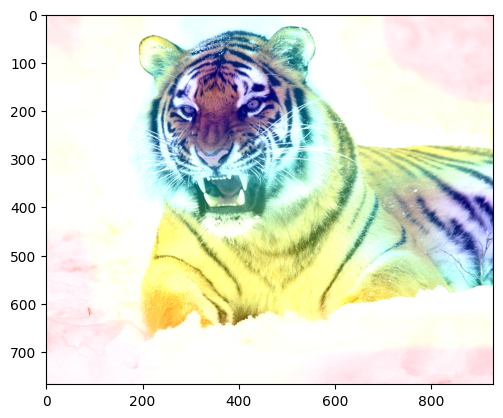

In [ ]:
plt.imshow(superimposed_img / 255.0)

## Gradcam with VGG16

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Define a preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
img_path = image_path  # Replace with your image path
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

# Choose the target convolutional layer
target_layer = model.features[-1]  # The last convolutional layer in VGG16

# Define hooks to capture gradients and activations
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])  # Gradients of the output w.r.t. feature maps

def forward_hook(module, input, output):
    activations.append(output)  # Feature maps from the forward pass

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()  # Predicted class index

# Backward pass for the predicted class
model.zero_grad()
output[0, pred_class].backward()

# Extract gradients and activations
grads = gradients[0].cpu().data.numpy()  # Gradients
acts = activations[0].cpu().data.numpy()  # Activations

# Compute Grad-CAM
weights = np.mean(grads, axis=(2, 3))  # Global average pooling of gradients
cam = np.zeros(acts.shape[2:], dtype=np.float32)

for i, w in enumerate(weights[0]):
    cam += w * acts[0, i, :, :]  # Weighted combination of feature maps

# Apply ReLU to keep only positive influences
cam = np.maximum(cam, 0)

# Normalize Grad-CAM heatmap to [0, 1]
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Resize the heatmap to the original image size
heatmap = cv2.resize(cam, (img.size[0], img.size[1]))

# Convert heatmap to color and overlay it on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = np.array(img) * 0.6 + heatmap * 0.4

# print predicted class
print(pred_class)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


292


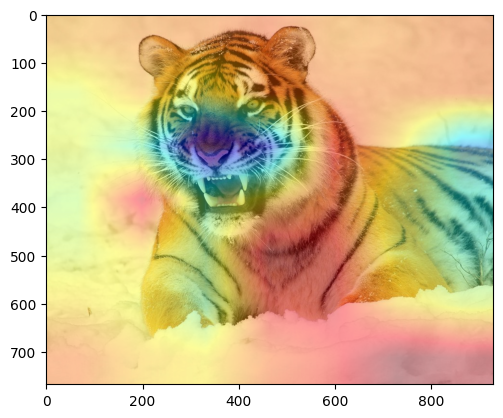

In [ ]:
plt.imshow(superimposed_img / 255.0)